In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install category_encoders

import category_encoders as ce

In [3]:
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, QuantileTransformer,
    LabelEncoder, OneHotEncoder, OrdinalEncoder)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
# 2. Load Dataset
titanic = sns.load_dataset('titanic')

# Select features & target
df = titanic[['class', 'sex', 'age', 'fare', 'embarked', 'survived']].copy()

# Introduce some missing values for demo (already present in Titanic)
df.head()


,class,sex,age,fare,embarked,survived
0,Third,male,22.0,7.2500,S,0
1,First,female,38.0,71.2833,C,1
2,Third,female,26.0,7.9250,S,1
3,First,female,35.0,53.1000,S,1
4,Third,male,35.0,8.0500,S,0


In [5]:
df = df[["age", "fare", "sex", "class", "embarked",  "survived"]].dropna()


In [6]:
# 3. Basic Data Info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       712 non-null    float64 
 1   fare      712 non-null    float64 
 2   sex       712 non-null    object  
 3   class     712 non-null    category
 4   embarked  712 non-null    object  
 5   survived  712 non-null    int64   
dtypes: category(1), float64(2), int64(1), object(2)
memory usage: 34.2+ KB
None


In [7]:
print(df.describe(include="all").T)

          count unique    top freq       mean        std   min   25%  \
age       712.0    NaN    NaN  NaN  29.642093  14.492933  0.42  20.0   
fare      712.0    NaN    NaN  NaN  34.567251  52.938648   0.0  8.05   
sex         712      2   male  453        NaN        NaN   NaN   NaN   
class       712      3  Third  355        NaN        NaN   NaN   NaN   
embarked    712      3      S  554        NaN        NaN   NaN   NaN   
survived  712.0    NaN    NaN  NaN   0.404494   0.491139   0.0   0.0   

               50%   75%       max  
age           28.0  38.0      80.0  
fare      15.64585  33.0  512.3292  
sex            NaN   NaN       NaN  
class          NaN   NaN       NaN  
embarked       NaN   NaN       NaN  
survived       0.0   1.0       1.0  


info() shows datatypes (which helps us know which features are categorical/numeric).

describe() summarizes statistics.

In [8]:

df.dropna(inplace=True)  # drop rows with missing values
df.head()


,age,fare,sex,class,embarked,survived
0,22.0,7.2500,male,Third,S,0
1,38.0,71.2833,female,First,C,1
2,26.0,7.9250,female,Third,S,1
3,35.0,53.1000,female,First,S,1
4,35.0,8.0500,male,Third,S,0


# **Scaling (Normalization & Standardization)**

#  Feature Scaling: Normalization vs. Standardization

Feature scaling is an essential preprocessing step in machine learning.  
Many algorithms (Linear Regression, Logistic Regression, SVMs, PCA, K-means, Neural Networks) rely on **distances, dot-products, or gradient descent**. If features are on very different scales, the model may become biased toward larger-magnitude features.

---

## Normalization (Min–Max Scaling)

**Definition:**  
Rescales values of a feature into a fixed range, usually [0, 1].  

\[$
x' = \frac{x - x_{\min}}{x_{\max} - x_{\min}}$
\]

- Each feature’s smallest value becomes 0, largest becomes 1.  
- Preserves the shape of the distribution, but **compresses** the scale.  
- Very sensitive to **outliers** (a single extreme value can stretch the scale).  

**When to use:**  
- Works well when features are bounded (e.g., pixel intensities between 0–255).  
- Useful in **Neural Networks** where inputs are often normalized.  
- Less suitable for features with heavy outliers.

---

## Standardization (Z-score Scaling)

**Definition:**  
Centers the feature at mean 0 and scales it to unit variance.  

\[$
x' = \frac{x - \mu}{\sigma}$
\]

where \(\mu\) is the feature mean and \(\sigma\) is the standard deviation.  

- The transformed feature has mean ≈ 0 and standard deviation ≈ 1.  
- Not limited to [0, 1]; values can be negative or greater than 1.  
- More **robust** than normalization when dealing with outliers.  
- Assumes features are roughly Gaussian (bell-shaped) for best results.  

**When to use:**  
- Default choice for **Linear/Logistic Regression, SVMs, PCA, and K-means**.  
- Works well when features have different units (e.g., age in years, fare in dollars).  
- Preserves outlier influence without compressing them to 0–1.

---

##  Choosing Between Normalization and Standardization

- If your model relies on **distance or dot-product geometry** (linear regression, SVM, PCA, neural networks) → **Standardization** is often better.  
- If you need features in a **bounded range** (e.g., image intensities, probability inputs) → **Normalization** works well.  
- With **tree-based models** (Decision Trees, Random Forests, XGBoost, CatBoost), scaling usually **doesn’t matter** because splits are not distance-based.  

---

##  Titanic Example (numeric features only)

In the Titanic dataset, consider two features:  
- **`age`** (in years, typically 0–80 but with some missing values).  
- **`fare`** (in dollars, highly skewed with very large outliers).  

- With **Normalization**, `fare` outliers (very expensive tickets) will squeeze the majority of passenger fares into a very narrow [0–0.1] range.  
- With **Standardization**, `fare` will be centered and scaled, but outliers will appear as large positive z-scores, which keeps more useful variation for linear models.  

---

**Summary:**  
- **Normalization:** good when bounded [0,1] values are needed, but sensitive to outliers.  
- **Standardization:** good for most ML algorithms, especially linear ones; robust to varying feature units.  


        age      fare     sex  class embarked  survived
0  0.271174  0.014151    male  Third        S         0
1  0.472229  0.139136  female  First        C         1
2  0.321438  0.015469  female  Third        S         1
3  0.434531  0.103644  female  First        S         1
4  0.434531  0.015713    male  Third        S         0


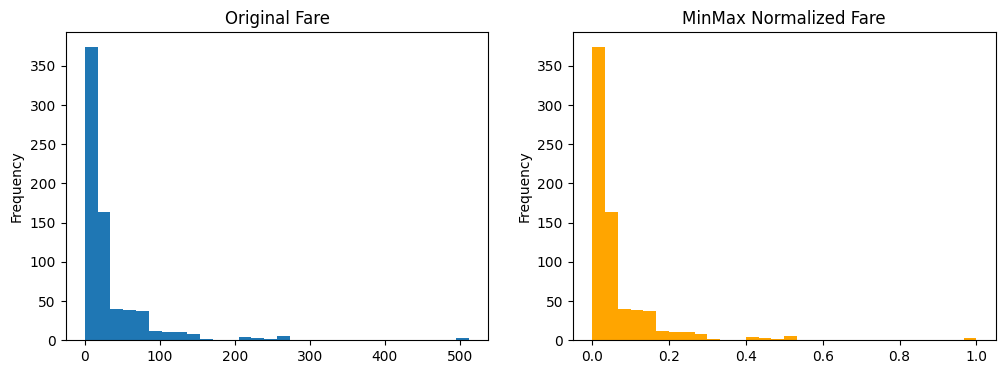

In [9]:
scaler = MinMaxScaler()
df_minmax = df.copy()
df_minmax[["age", "fare"]] = scaler.fit_transform(df[["age", "fare"]])

print(df_minmax.head())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df["fare"].plot(kind="hist", bins=30, ax=axes[0], title="Original Fare")
df_minmax["fare"].plot(kind="hist", bins=30, ax=axes[1], title="MinMax Normalized Fare", color="orange")
plt.show()
# Rescales values between 0 and 1. Useful when features have different ranges.


        age      fare     sex  class embarked  survived
0 -0.527669 -0.516380    male  Third        S         0
1  0.577094  0.694046  female  First        C         1
2 -0.251478 -0.503620  female  Third        S         1
3  0.369951  0.350326  female  First        S         1
4  0.369951 -0.501257    male  Third        S         0


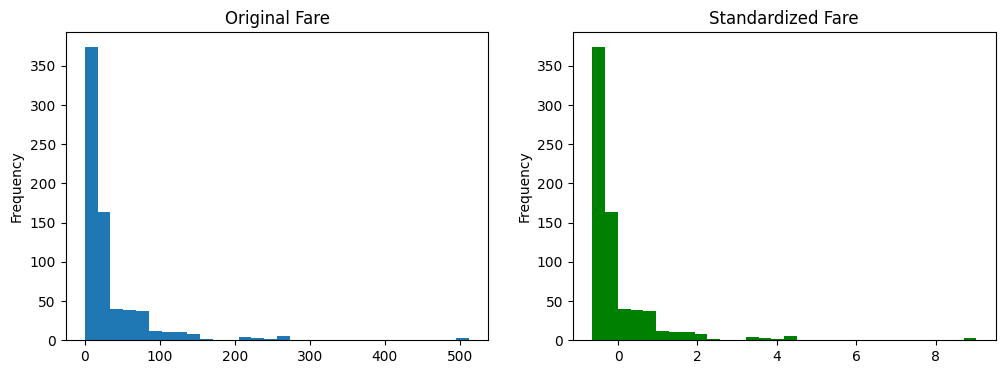

In [10]:
scaler = StandardScaler()
df_standard = df.copy()
df_standard[["age", "fare"]] = scaler.fit_transform(df[["age", "fare"]])

print(df_standard.head())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df["fare"].plot(kind="hist", bins=30, ax=axes[0], title="Original Fare")
df_standard["fare"].plot(kind="hist", bins=30, ax=axes[1], title="Standardized Fare", color="green")
plt.show()
# Transforms to mean=0, std=1. Best for models assuming Gaussian-like features.

##  QuantileTransformer

**What it does:**  
- Transforms features to follow a **target distribution** by mapping quantiles.  
- Two main options in scikit-learn:  
  - `output_distribution="uniform"` → transforms features into [0, 1] uniform distribution.  
  - `output_distribution="normal"` → transforms features into standard normal (mean=0, var=1).  

**How it works:**  
- Computes the empirical CDF (cumulative distribution function) of the data.  
- Maps each value to its quantile, then to the chosen output distribution.  

**Properties:**  
- Makes distributions **more Gaussian-like** (if `normal`).  
- Very robust to **outliers** (they get compressed into the tails).  
- Non-linear transformation → changes relationships between features.  

**When to use:**  
- Features are highly skewed, long-tailed, or non-Gaussian.  
- Useful before algorithms that are sensitive to non-normality (e.g., linear models, Gaussian-based methods).  
- Works well when feature scales are very irregular.  

---

##  StandardScaler vs. QuantileTransformer

| Aspect | StandardScaler | QuantileTransformer |
|--------|----------------|----------------------|
| Effect on Mean/Variance | Centers to mean 0, var 1 | Shapes data into uniform [0,1] or normal |
| Handles Outliers | No (keeps them extreme) | Yes (compresses them into tails) |
| Distribution Shape | Preserved (still skewed if original is skewed) | Changed (forces uniform or normal) |
| Use Case | Roughly Gaussian data, not too skewed | Highly skewed, heavy-tailed, or irregular data |

---

##  Titanic Example (numeric feature: `fare`)

- **StandardScaler:**  
  - `fare` will be centered at 0, variance = 1.  
  - Extremely high fares remain large positive z-scores.  
- **QuantileTransformer (normal):**  
  - `fare` distribution becomes closer to Gaussian.  
  - Very expensive tickets are pushed into the far right tail but less extreme.  

---

 **Summary:**  
- Use **StandardScaler** when features are moderately well-behaved (close to Gaussian).  
- Use **QuantileTransformer** when features are **skewed** or have **outliers**, and you want a Gaussian or uniform output distribution.  

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (712). n_quantiles is set to n_samples.
  warnings.warn(


        age      fare     sex  class embarked  survived
0  0.304501  0.071027    male  Third        S         0
1  0.746132  0.870605  female  First        C         1
2  0.434599  0.213080  female  Third        S         1
3  0.684951  0.828411  female  First        S         1
4  0.684951  0.246835    male  Third        S         0


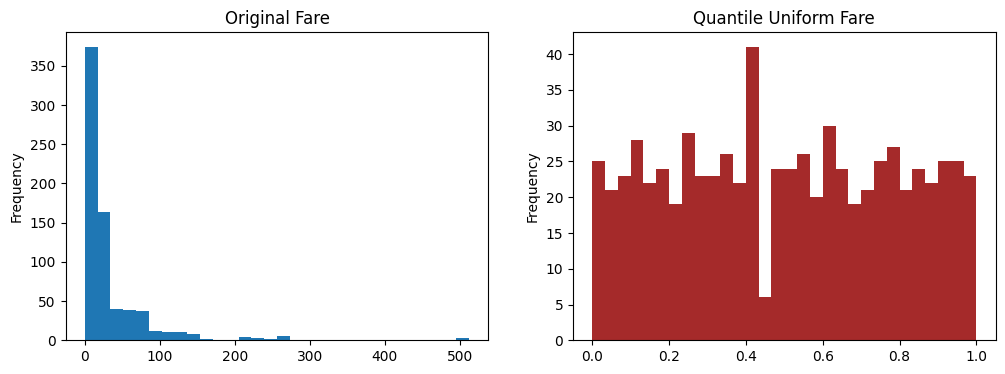

In [11]:
scaler = QuantileTransformer(output_distribution="uniform")
df_quantile_uniform = df.copy()
df_quantile_uniform[["age", "fare"]] = scaler.fit_transform(df[["age", "fare"]])

print(df_quantile_uniform.head())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df["fare"].plot(kind="hist", bins=30, ax=axes[0], title="Original Fare")
df_quantile_uniform["fare"].plot(kind="hist", bins=30, ax=axes[1], title="Quantile Uniform Fare", color="brown")
plt.show()
# Maps values → uniform [0,1] distribution.

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (712). n_quantiles is set to n_samples.
  warnings.warn(


        age      fare     sex  class embarked  survived
0 -0.511499 -1.468187    male  Third        S         0
1  0.662368  1.129255  female  First        C         1
2 -0.164677 -0.795779  female  Third        S         1
3  0.481588  0.947903  female  First        S         1
4  0.481588 -0.684482    male  Third        S         0


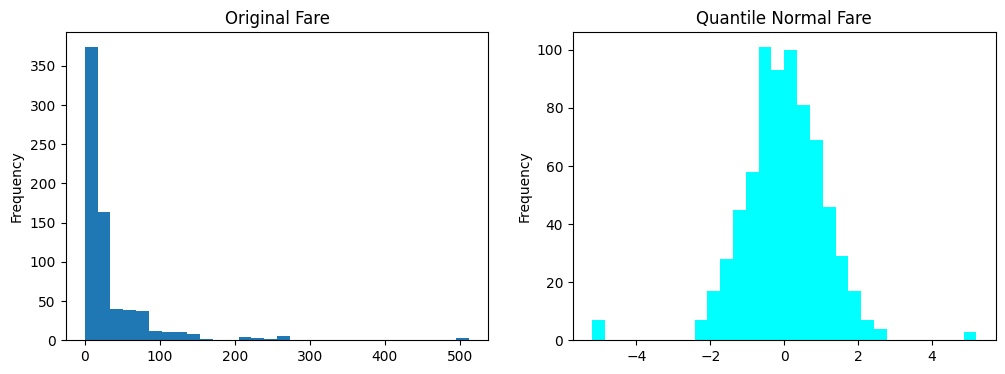

In [12]:
scaler = QuantileTransformer(output_distribution="normal")
df_quantile_normal = df.copy()
df_quantile_normal[["age", "fare"]] = scaler.fit_transform(df[["age", "fare"]])

print(df_quantile_normal.head())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df["fare"].plot(kind="hist", bins=30, ax=axes[0], title="Original Fare")
df_quantile_normal["fare"].plot(kind="hist", bins=30, ax=axes[1], title="Quantile Normal Fare", color="cyan")
plt.show()
# Forces values to follow a normal distribution.

# **Encoding**

#  Why Do We Need Encoding?

Machine learning models usually work with **numerical features**.  
But in many datasets (like Titanic), we have **categorical features** such as:

- `sex` → {male, female}  
- `embarked` → {C, Q, S}  
- `class` → {First, Second, Third}  

These values are **labels**, not numbers.  
If we feed them directly into most ML algorithms, they will not understand the categories.  

 **Encoding** is the process of converting categorical variables into numeric form so that models can use them.

---

##  Label Encoding

**How it works:**  
- Assigns each category a unique integer.  

Example:  
- `sex`: {male → 0, female → 1}  
- `embarked`: {C → 0, Q → 1, S → 2}  

**Advantages:**  
- Simple and compact.  
- Works well for **tree-based models** (Decision Trees, Random Forest, XGBoost), since they split based on thresholds, not distances.  

**Disadvantages:**  
- Imposes a **fake order** (0 < 1 < 2), which can mislead models like Linear Regression, Logistic Regression, or SVM (they may think `S` > `Q` > `C`).  

---

##  One-Hot Encoding (OHE)

**How it works:**  
- Creates a new **binary column for each category**.  
- Value is `1` if the row belongs to that category, else `0`.  

Example: `embarked` → {C, Q, S}  

| embarked | embarked_C | embarked_Q | embarked_S |
|----------|------------|------------|------------|
| C        | 1          | 0          | 0          |
| S        | 0          | 0          | 1          |
| Q        | 0          | 1          | 0          |

**Advantages:**  
- Avoids false ordinal relationships.  
- Safe default for **linear models, logistic regression, SVMs, and neural networks**.  

**Disadvantages:**  
- Increases the number of features (can be large if categories are many).  
- Can lead to **sparse matrices** with high-cardinality categorical variables.  

---

## When to Use Which?

- **Tree-based models (Decision Trees, Random Forest, Gradient Boosting):**  
  → Label Encoding is fine (trees handle categories by splitting, not by distances).  

- **Linear models, Logistic Regression, SVMs, Neural Networks:**  
  → One-Hot Encoding is preferred (no fake ordering).  

- **High cardinality (hundreds/thousands of categories):**  
  → Consider advanced techniques like **Target Encoding, Frequency Encoding, or Hashing**.  

---

**Summary:**  
- **Label Encoding** → compact, but risky for linear models.  
- **One-Hot Encoding** → more features, but safer for most models.  
- Always choose encoding based on **model type** and **data characteristics**.  


In [16]:
categorical_features = ["sex", "embarked","class"]

# 1. Label Encoding
le = LabelEncoder()
df_label = df.copy()
for col in categorical_features:
    df_label[col] = le.fit_transform(df[col])
print("Label Encoding:\n", df_label, "\n")

Label Encoding:
       age     fare  sex  class  embarked  survived
0    22.0   7.2500    1      2         2         0
1    38.0  71.2833    0      0         0         1
2    26.0   7.9250    0      2         2         1
3    35.0  53.1000    0      0         2         1
4    35.0   8.0500    1      2         2         0
..    ...      ...  ...    ...       ...       ...
885  39.0  29.1250    0      2         1         0
886  27.0  13.0000    1      1         2         0
887  19.0  30.0000    0      0         2         1
889  26.0  30.0000    1      0         0         1
890  32.0   7.7500    1      2         1         0

[712 rows x 6 columns] 



In [17]:
# 2. One-Hot Encoding
df_onehot = pd.get_dummies(df, columns=categorical_features, drop_first=True)
print("One-Hot Encoding:\n", df_onehot.head(), "\n")

One-Hot Encoding:
     age     fare  survived  sex_male  embarked_Q  embarked_S  class_Second  \
0  22.0   7.2500         0      True       False        True         False   
1  38.0  71.2833         1     False       False       False         False   
2  26.0   7.9250         1     False       False        True         False   
3  35.0  53.1000         1     False       False        True         False   
4  35.0   8.0500         0      True       False        True         False   

   class_Third  
0         True  
1        False  
2         True  
3        False  
4         True   



# 🎛️ Beyond One-Hot and Label Encoding: Advanced Encodings


##  Ordinal Encoding

**What it does:**  
- Maps categories to integers **preserving their natural order**.  

Example (Titanic `class`):  
- First → 3  
- Second → 2  
- Third → 1  

**Why:**  
- `class` is truly ordered (First > Second > Third).  
- Unlike generic Label Encoding, the ordering here makes sense.  

**Use case:**  
- Works well for features with meaningful hierarchy (education level, size: small/medium/large, etc.).  
- Safe for linear models if the relationship is monotonic.

---



In [18]:
# 3. Ordinal Encoding (for ordered categories like 'class')
ord_enc = OrdinalEncoder(categories=[["Third", "Second", "First"]])
df_ord = df.copy()
df_ord["class"] = ord_enc.fit_transform(df[["class"]])
print("Ordinal Encoding:\n", df_ord[["class"]], "\n")
# Ordinal Encoding (for ordered categories like class = [Third < Second < First])

Ordinal Encoding:
      class
0      0.0
1      2.0
2      0.0
3      2.0
4      0.0
..     ...
885    0.0
886    1.0
887    2.0
889    2.0
890    0.0

[712 rows x 1 columns] 



## ✅ Target Encoding

**What it does:**  
- Replaces each category with a **statistic of the target variable** (commonly the mean).  

Example (Titanic `sex` with target = `survived`):  
- Female → survival rate ≈ 0.74  
- Male → survival rate ≈ 0.19  

So `sex` becomes:  
- Female → 0.74  
- Male → 0.19  

**Why:**  
- Collapses categorical values into **one numeric feature**.  
- Very powerful for **high-cardinality features** (like hundreds of ZIP codes).  

---


In [19]:
# 4. Target Encoding (Mean of survived per category)
encoder_target = ce.TargetEncoder(cols=["embarked"])
df_target = encoder_target.fit_transform(df[["embarked"]], df["survived"])

print("After Target Encoding (Embarked):")
print(df_target)
# Replace categories with mean of target (survived).

After Target Encoding (Embarked):
     embarked
0    0.362816
1    0.607689
2    0.362816
3    0.362816
4    0.362816
..        ...
885  0.322539
886  0.362816
887  0.362816
889  0.607689
890  0.322539

[712 rows x 1 columns]



## ✅ Binary Encoding

**What it does:**  
- Converts category indices into **binary digits** and places them across new columns.  
- A balance between Label and One-Hot: fewer columns than OHE, but no fake ordering.  

Example (imagine `embarked` has categories C=0, Q=1, S=2):  
- 0 → 00  
- 1 → 01  
- 2 → 10  

So we get two binary columns:  

| embarked | bin1 | bin2 |
|----------|------|------|
| C (0)    |  0   |  0   |
| Q (1)    |  0   |  1   |
| S (2)    |  1   |  0   |

**Use case:**  
- Good for **moderate or high-cardinality** features where OHE would explode in dimensionality.  
- Still keeps categories separated better than plain Label Encoding.

---


 **Key Takeaway:**  
- Choose encoding by **nature of the feature** and **model type**.  
- Use Ordinal for true orders, One-Hot for nominal categories in linear models, Target/Binary for high-cardinality, Helmert for statistical interpretability.


In [20]:
# 5. Binary Encoding
encoder = ce.BinaryEncoder(cols=["embarked"])
df_binary = encoder.fit_transform(df[["embarked"]])

print("Original values:\n", df["embarked"].unique())
print("\nAfter Binary Encoding:\n", df_binary)
# Binary Encoding (convert categories into binary digits → fewer columns than one-hot)

Original values:
 ['S' 'C' 'Q']

After Binary Encoding:
      embarked_0  embarked_1
0             0           1
1             1           0
2             0           1
3             0           1
4             0           1
..          ...         ...
885           1           1
886           0           1
887           0           1
889           1           0
890           1           1

[712 rows x 2 columns]



##  Summary Table

| Encoding Type   | Best For | Pros | Cons |
|-----------------|----------|------|------|
| **Ordinal**     | Ordered categories (class, size) | Simple, preserves hierarchy | Wrong if order is artificial |
| **Target**      | High-cardinality categorical | Compresses info, powerful | Risk of leakage, must use CV |
| **Binary**      | Medium/high-cardinality | Fewer features than OHE | Less interpretable |


---

In [24]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Titanic dataset
titanic = sns.load_dataset('titanic').dropna(subset=['fare'])
X = titanic[['pclass','sex','age','sibsp','parch','embarked']]
y = titanic['fare']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Columns
num_features = ['pclass','age','sibsp','parch']
cat_features = ['sex','embarked']

def build_pipe(scaler, encoder):
    num_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('scale', scaler)
    ])
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('encode', encoder)
    ])
    pre = ColumnTransformer([
        ('num', num_pipe, num_features),
        ('cat', cat_pipe, cat_features)
    ])
    return Pipeline([('pre', pre), ('lr', LinearRegression())])

# Pipelines to compare
pipelines = {
    "Normalization + OHE": build_pipe(MinMaxScaler(), OneHotEncoder(drop='first', handle_unknown='ignore')),
    "Standardization + OHE": build_pipe(StandardScaler(), OneHotEncoder(drop='first', handle_unknown='ignore')),
    "Standardization + Label": build_pipe(StandardScaler(), OrdinalEncoder()),
}

# Fit, predict, and compare
results = []
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

df_results = pd.DataFrame(results).sort_values(by="RMSE")
print(df_results.to_string(index=False))


                  Model       MAE      RMSE       R2
Standardization + Label 20.837023 30.470255 0.400014
  Standardization + OHE 20.809398 30.473145 0.399900
    Normalization + OHE 20.809398 30.473145 0.399900
